In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit

plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

In [2]:
file_name = "../mediciones/D.D/Tiempo de respuesta del laser/0.5 Hz 0.5 Amp 2 OFFS 50 Ohms.pickle"
# Cargamos los datos
with open(file_name, "rb") as f:
    dic = pickle.load(f)

offset = 2

In [3]:
t_1, V_1 = dic[f"{offset}V"]["t_1"],dic[f"{offset}V"]["V_1"]
t_2, V_2 = dic[f"{offset}V"]["t_2"],dic[f"{offset}V"]["V_2"]

# Visualizando las mediciones

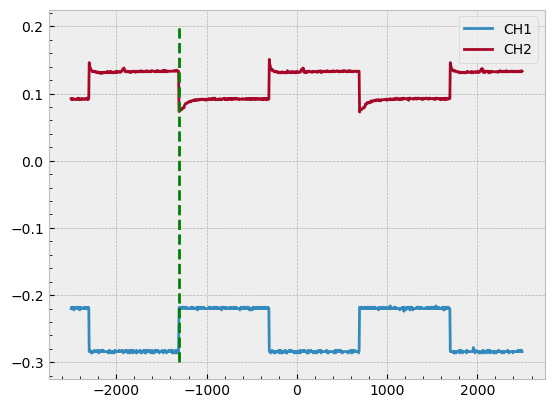

In [4]:
plt.plot(t_1, V_1, label = "CH1")
plt.plot(t_2, V_2, label = "CH2")
plt.vlines(-1305, ymin = -0.3, ymax = 0.2, ls = "--", color = "g")
# plt.xlim(-1320,-1300)
plt.legend()
plt.show()

# Reescaleando las señales

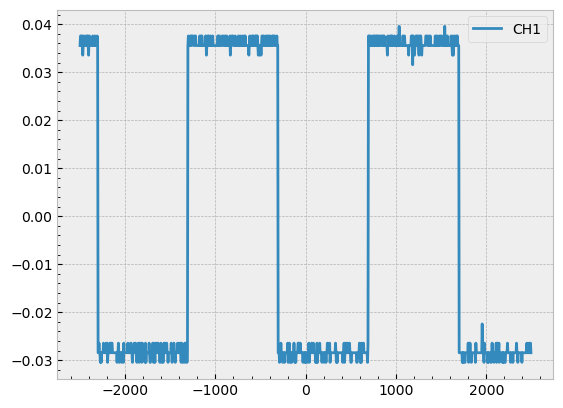

In [5]:
plt.plot(t_1, V_1-np.mean(V_1), label = "CH1")
plt.legend()
plt.show()

In [6]:
V_1_shifted = V_1-np.mean(V_1)
V_1_max = np.mean(V_1_shifted[V_1_shifted > 0])
V_1_min  = np.mean(V_1_shifted[V_1_shifted < 0])

V_1_amp = (V_1_max-V_1_min)/2
print(V_1_amp)

0.032272940422442095


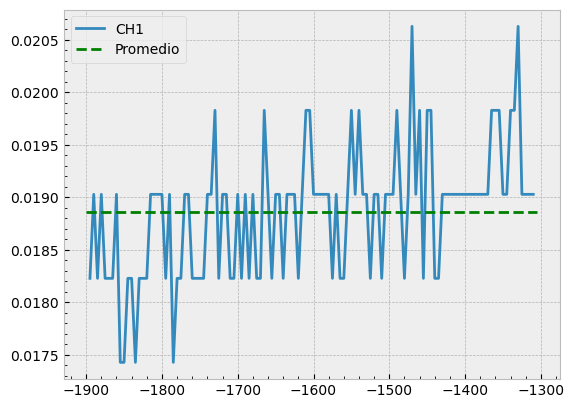

In [7]:
# Hallando el máximo
plt.plot(t_2[(-1305 > t_2) & (t_2 > -1900)], (V_2-np.mean(V_2))[(-1305 > t_2) & (t_2 > -1900)], label = "CH1")
plt.hlines(np.mean((V_2-np.mean(V_2))[(-1305 > t_2) & (t_2 > -1900)]),xmin = -1900, xmax = -1305, ls = "--", color = "g", label = "Promedio")
plt.legend()
plt.show()

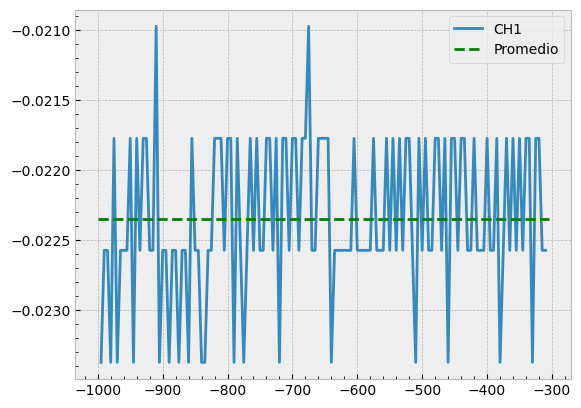

In [8]:
# Hallando el mínimo
t_max = -305
t_min = -1000
plt.plot(t_2[(t_max > t_2) & (t_2 > t_min)], (V_2-np.mean(V_2))[(t_max > t_2) & (t_2 > t_min)], label = "CH1")
plt.hlines(np.mean((V_2-np.mean(V_2))[(t_max > t_2) & (t_2 > t_min)]),xmin = t_min, xmax = t_max, ls = "--", color = "g", label = "Promedio")
plt.legend()
plt.show()

In [9]:
V_2_max = np.mean((V_2-np.mean(V_2))[(-1305 > t_2) & (t_2 > -1900)])
V_2_min  = np.mean((V_2-np.mean(V_2))[(-305 > t_2) & (t_2 > -1000)])

V_2_amp = (V_2_max-V_2_min)/2
print(V_2_amp)

0.020602210759027267


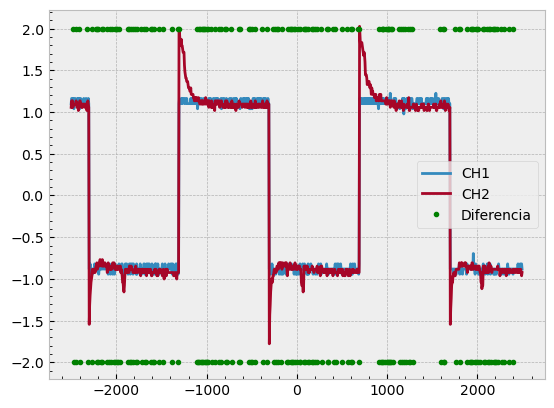

In [10]:
V_1_reescaled = (V_1-np.mean(V_1))/V_1_amp
V_2_reescaled = -(V_2-np.mean(V_2))/V_2_amp

channel_diff = np.diff(np.sign(V_2_reescaled - V_1_reescaled))
index = np.argwhere(channel_diff).flatten()

plt.plot(t_1, V_1_reescaled, label = "CH1")
plt.plot(t_2, V_2_reescaled, label = "CH2")
plt.plot(t_1[index], channel_diff[index],".", color = "g", label = "Diferencia")
plt.legend()
plt.show()

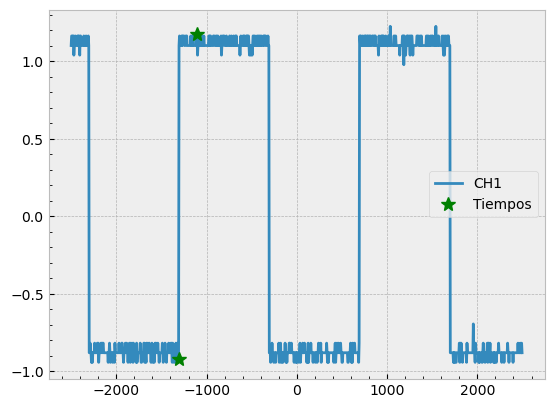

In [11]:
ind_r = index[(t_2[index] > -1200)][0]
ind_s = index[(t_2[index] < -1200)][-1]

plt.plot(t_1, V_1_reescaled, label = "CH1")
# plt.plot(t_2[index], V_2_reescaled[index], label = "CH2", marker = ".", ls = "")
# plt.plot(t_1[index], channel_diff[index],".", color = "g", label = "Diferencia")
# plt.plot(t_1[index][:-1][(V_2_reescaled[index][1:] > 0) & (V_2_reescaled[index][:-1] < 0)], V_2_reescaled[index][:-1][(V_2_reescaled[index][1:] > 0) & (V_2_reescaled[index][:-1] < 0)], color = "g")
plt.plot(t_2[np.array([ind_r,ind_s])], V_2_reescaled[np.array([ind_r,ind_s])], c='g', label='Tiempos', marker = "*", ls = "", ms = 10)
plt.legend()
plt.show()

In [12]:
abs(np.diff(t_2[np.array([ind_r,ind_s])]))[0]*1e-3

0.2

In [13]:
t_r = t_2[index][(t_2[index] > -1200)][0]
t_s = t_2[index][(t_2[index] < -1200)][-1]

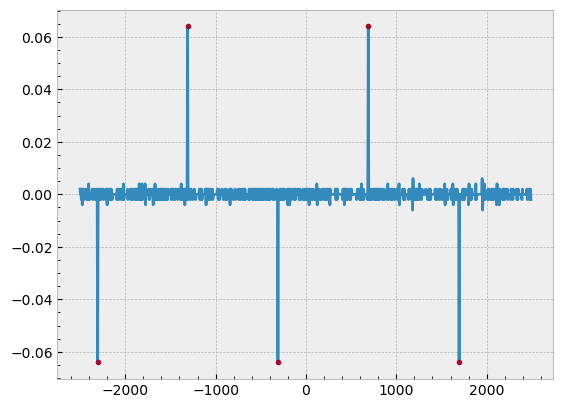

In [14]:
plt.plot(t_1[:-1],np.diff(V_1))
plt.plot(t_1[:-1][np.abs(np.diff(V_1)) > 0.01],np.diff(V_1)[np.abs(np.diff(V_1)) > 0.01],".")
plt.show()

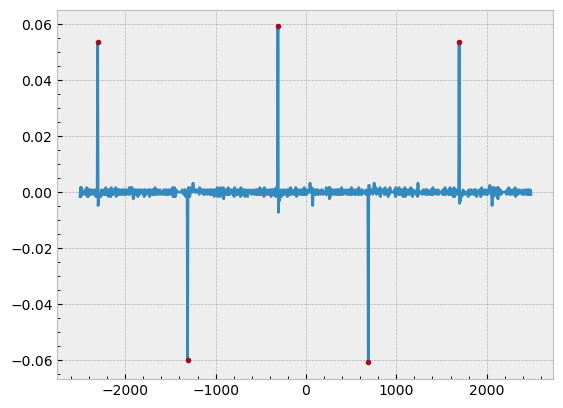

In [15]:
plt.plot(t_2[:-1],np.diff(V_2))
plt.plot(t_2[:-1][np.abs(np.diff(V_2)) > 0.01],np.diff(V_2)[np.abs(np.diff(V_2)) > 0.01],".")
plt.show()